<a href="https://colab.research.google.com/github/PierluigiRiti2/Android/blob/master/QuantumDeepFakeProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Readme
This noteboo is used to collect in one clean place all the code I have developed until now for the processing of an image with Quantum Machine Learning.<br/>
The goal is to used QML, Quantum Machine Learning, to correctly classify Deepfake.

# Section 1


In [1]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.5 MB 23.5 MB/s 
     |████████████████████████████████| 18.0 MB 48.1 MB/s 
     |████████████████████████████████| 240 kB 66.1 MB/s 
     |████████████████████████████████| 198 kB 56.0 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 112 kB 36.5 MB/s 
     |████████████████████████████████| 1.6 MB 34.5 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
     |████████████████████████████████| 943 kB 45.4 MB/s 
     |████████████████████████████████| 37.5 MB 1.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
     |████████████████████████████████| 4.0 MB 46.3 MB/s 
     |████████████████████████████████| 112 kB 62.3 MB/s 
  Created wheel for qiskit: filename=qiskit-0.36.2-py3-none-any.whl size=11933 sha256=50a5e6cf

In [5]:
from qiskit import QuantumCircuit, transpile, assemble, Aer
#from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
#from qiskit import QuantumCircuit, assemble, Aer
from math import sqrt, pi

import numpy as np
import skimage.color
import skimage.io
import matplotlib.pyplot as plt

In [3]:
def generate_histogram_blue(image_path):
  # tuple to select colors of each channel line
  channel_id =  2

  image = skimage.io.imread(fname=image_path)

  histogram, bin_edges = np.histogram(
      image[:, :, channel_id], bins=256, range=(0,256))

  return histogram, bin_edges

  # Convert the raw pixel values to probability amplitudes
def amplitude_encode(hist_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(hist_data**2)))

    # Create normalized image
    image_norm = []
    for arr in hist_data:
      image_norm.append(arr / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Section 2
Create the histogram with the Blue channel of the image

In [6]:
# Histogram of the original image
histogram_original, bin_edges_original = generate_histogram_blue("/content/drive/MyDrive/dataset/images/original/fadg0-original.jpg")
# histogram of the fake image
histogram_fake, bin_edges_fake = generate_histogram_blue("/content/drive/MyDrive/dataset/images/fake/fadg0-sa1.jpg")

In [7]:
# Get the amplitude ancoded pixel values
# Original Image
amplitude_original = amplitude_encode(histogram_original)

# Fake Image
amplitude_fake = amplitude_encode(histogram_fake)

In [8]:
# Initialize some global variable for number of qubits
data_qb = 8
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

In [9]:
# Create the Quantum Circuit
sim = Aer.get_backend('aer_simulator')  # Tell Qiskit how to simulate our circuit

qc_original = QuantumCircuit(total_qb)
qc_original.initialize(amplitude_original, range(1, total_qb))
qc_original.save_statevector()   # Tell simulator to save statevector
qobj_original = assemble(qc_original)     # Create a Qobj from the circuit for the simulator to run
result_original = sim.run(qobj_original).result() # Do the simulation and return the result
out_state_original = result_original.get_statevector()
counts_original = result_original.get_counts() #Count the value for the histogram

qc_original.measure_all()
qc_original.draw() # Draw the circuit

# Create the circuit for vertical scan
qc_fake = QuantumCircuit(total_qb)
qc_fake.initialize(amplitude_fake, range(1, total_qb))
qc_fake.save_statevector()   # Tell simulator to save statevector
qobj_fake = assemble(qc_fake)     # Create a Qobj from the circuit for the simulator to run
result_fake = sim.run(qobj_fake).result() # Do the simulation and return the result
out_state_fake = result_fake.get_statevector()
counts_fake = result_fake.get_counts() # Count the value for the histogram

qc_fake.measure_all()
qc_fake.draw()

# Combine both circuits into a single list
circ_list = [qc_original, qc_fake]

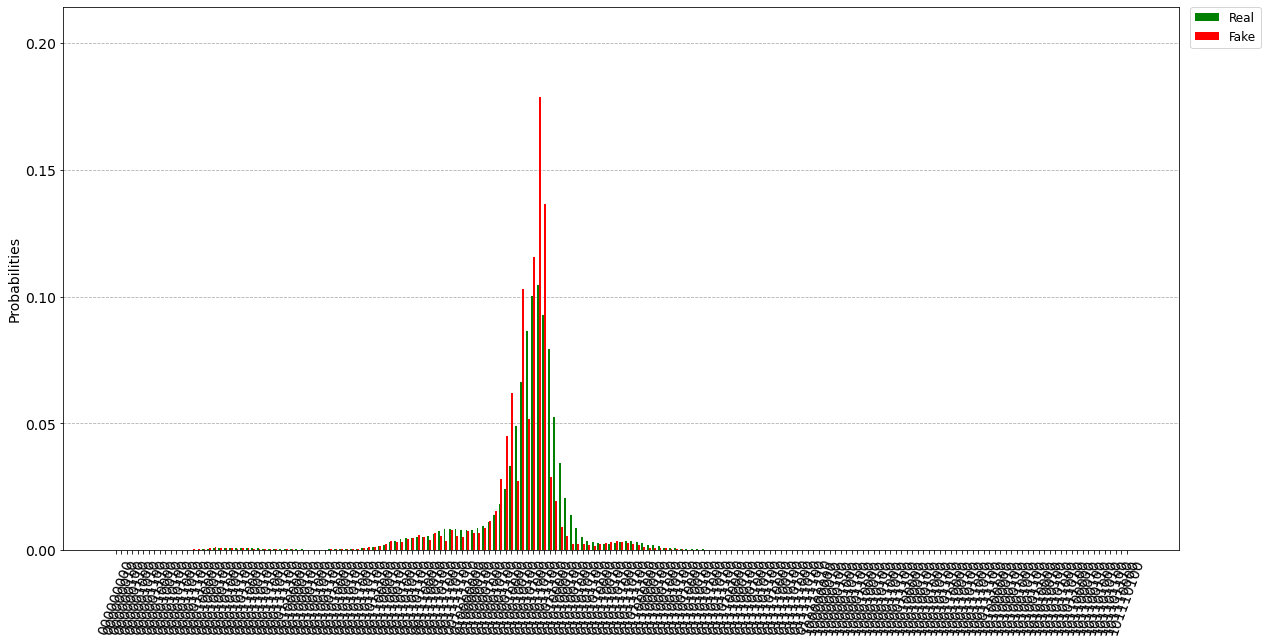

In [26]:
legend = ['Real', 'Fake']
plot_histogram([counts_original, counts_fake],  figsize=(20,10),
               color=['green', 'red'], legend=legend, bar_labels=False)

# Section 3
Create 14 qubit circuit with StateVector simulator

In [30]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

import random

In [37]:
circ = QuantumCircuit(20, 20)

# Initialize with a Hadamard layer
circ.h(range(20))
# Apply some random CNOT and T gates
qubit_indices = [i for i in range(20)]
for i in range(10):
    control, target, t = random.sample(qubit_indices, 3)
    circ.cx(control, target)
    circ.t(t)
circ.measure(range(20), range(20))

In [38]:
# Create statevector method simulator
statevector_simulator = AerSimulator(method='statevector')

# Transpile circuit for backend
tcirc = transpile(circ, statevector_simulator)

# Try and run circuit
statevector_result =  statevector_simulator.run(tcirc, shots=1).result()
print('This succeeded?: {}'.format(statevector_result.success))
print('Why not? {}'.format(statevector_result.status))

This succeeded?: True
Why not? COMPLETED


In [34]:
print(tcirc.draw())

          ┌───┐               ┌─┐                                             »
 q_0: ────┤ H ├───────────────┤M├─────────────────────────────────────────────»
          ├───┤               └╥┘             ┌───┐┌───┐                      »
 q_1: ────┤ H ├────────────■───╫──────────────┤ X ├┤ T ├──────────────────────»
          ├───┤     ┌───┐  │   ║              └─┬─┘└───┘     ┌─┐              »
 q_2: ────┤ H ├─────┤ X ├──┼───╫───────────■────┼────────────┤M├──────────────»
          ├───┤     └─┬─┘  │   ║    ┌───┐  │    │            └╥┘┌─┐           »
 q_3: ────┤ H ├───────■────┼───╫────┤ X ├──┼────┼─────────────╫─┤M├───────────»
          ├───┤            │   ║    └─┬─┘  │    │  ┌───┐      ║ └╥┘┌─┐        »
 q_4: ────┤ H ├────────────┼───╫──────┼────┼────┼──┤ X ├──────╫──╫─┤M├────────»
      ┌───┴───┴───┐        │   ║      │    │    │  └─┬─┘      ║  ║ └╥┘        »
 q_5: ┤ U2(-π,-π) ├────────┼───╫──────┼────┼────┼────┼────────╫──╫──╫─────────»
      └───┬───┬───┘        │   ║ ┌─┐  │ 

Test the histogram for a BW Image to see if the difference remain, classical way

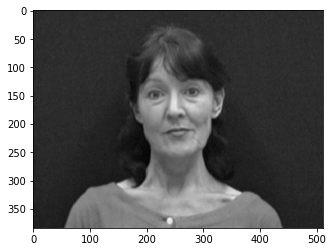

In [40]:
import numpy as np
import skimage.color
import skimage.io
import matplotlib.pyplot as plt

# read the image of a plant seedling as grayscale from the outset
#image = skimage.io.imread(fname="/content/drive/MyDrive/dataset/images/original/fadg0-original.jpg", as_gray=True)
image = skimage.io.imread(fname="/content/drive/MyDrive/dataset/images/original/fadg0-original.jpg", as_gray = True)

# display the image
fig, ax = plt.subplots()
plt.imshow(image, cmap="gray")
#plt.imshow(image)
plt.show()

In [49]:
print(image)

[[0.20746431 0.18001333 0.19569961 ... 0.19539412 0.19931569 0.19203804]
 [0.19793961 0.16824863 0.18785647 ... 0.19931569 0.19988118 0.19203804]
 [0.1861749  0.16656706 0.1839349  ... 0.19931569 0.19203804 0.18811647]
 ...
 [0.16652235 0.15867922 0.15083608 ... 0.16200471 0.15808314 0.16984784]
 [0.16652235 0.15867922 0.15083608 ... 0.17182    0.16397686 0.17182   ]
 [0.15867922 0.15867922 0.15532314 ... 0.18358471 0.16789843 0.16789843]]


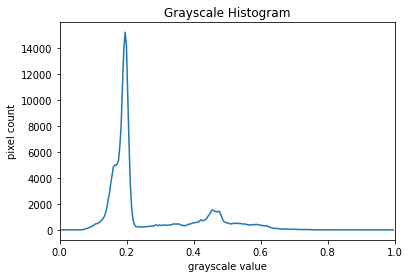

In [50]:
histogram, bin_edges = np.histogram(image, bins=256, range=(0, 1))

plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

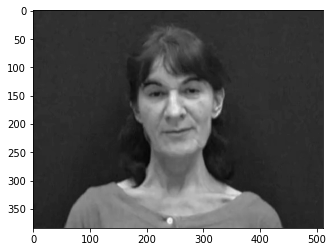

In [52]:
image = skimage.io.imread(fname="/content/drive/MyDrive/dataset/images/fake/fadg0-sa1.jpg",as_gray = True)

# display the image
fig, ax = plt.subplots()
plt.imshow(image, cmap="gray")
#plt.imshow(image)
plt.show()

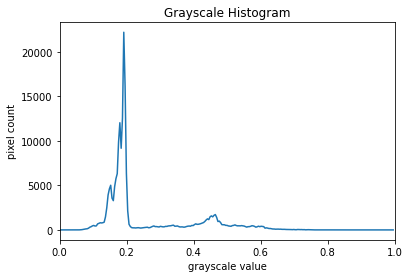

In [53]:
histogram, bin_edges = np.histogram(image, bins=256, range=(0, 1))

plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

In [60]:
def generate_multi_graph(original_path, fake_path):
  # tuple to select colors of each channel line
  channel_id =  2

  fake = skimage.io.imread(fname=fake_path,as_gray = True)
  original = skimage.io.imread(fname=original_path,as_gray = True)

  # fake histogram
  histogram_fake, bin_edges_fake = np.histogram(fake, bins=256, range=(0, 1))

  # original histogram
  histogram_original, bin_edges_original = np.histogram(original, bins=256, range=(0, 1))


  plt.figure()
  plt.xlim([0.0, 1.0])  
  plt.rcParams["figure.figsize"] = (15,15)


  # Plotting both the curves simultaneously
  plt.plot(bin_edges_original[0:-1], histogram_original ,color='r', label="Original Image") 
  plt.plot(bin_edges_fake[0:-1], histogram_fake,color='g', label="Fake Image")

  
  plt.title("Color Histogram")
  plt.xlabel("Color value")
  plt.ylabel("Pixel count")

  plt.legend()

  return plt.show()

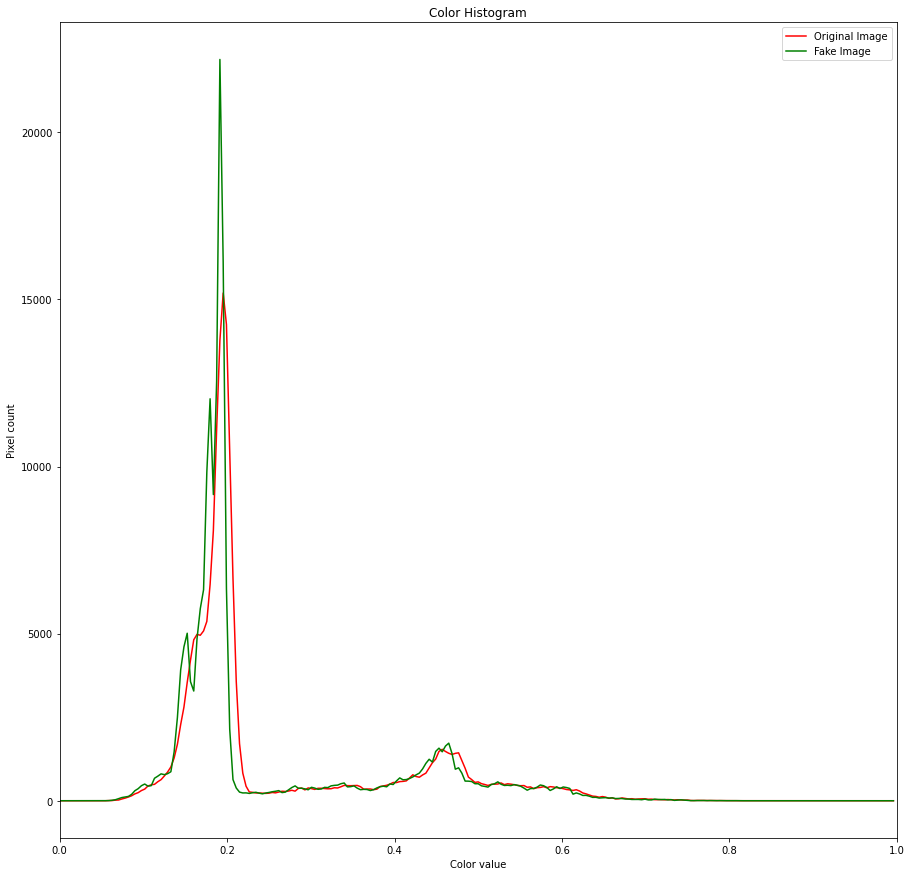

In [61]:
generate_multi_graph("/content/drive/MyDrive/dataset/images/original/fadg0-original.jpg",
                     "/content/drive/MyDrive/dataset/images/fake/fadg0-sa1.jpg")